<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-Importance-of-Data-Scaling-in-PCovR-/-KernelPCovR" data-toc-modified-id="The-Importance-of-Data-Scaling-in-PCovR-/-KernelPCovR-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The Importance of Data Scaling in PCovR / KernelPCovR</a></span></li></ul></div>

# The Importance of Data Scaling in PCovR / KernelPCovR

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from skcosmo.decomposition import PCovR

In PCovR, and KernelPCovR, we are combining multiple aspects of the dataset, primarily the features and targets. 
As such, the results largely depend on the relative contributions of each aspect to the mixed model.

In [2]:
X, y = load_boston(return_X_y=True)

Take the boston housing prices from sklearn. In their raw form, the magnitudes of the features and targets are

In [3]:

print(
    "Norm of the features: %0.2f \nNorm of the targets: %0.2f"
    % (np.linalg.norm(X), np.linalg.norm(y))
)

Norm of the features: 13072.86 
Norm of the targets: 547.38


For the boston dataset, we can use the `StandardScaler` class from sklearn, as the features and targets are independent.

In [4]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1,1)).reshape(y.shape)

Looking at the results at `mixing=0.5`, we see an especially large difference in the latent-space projections

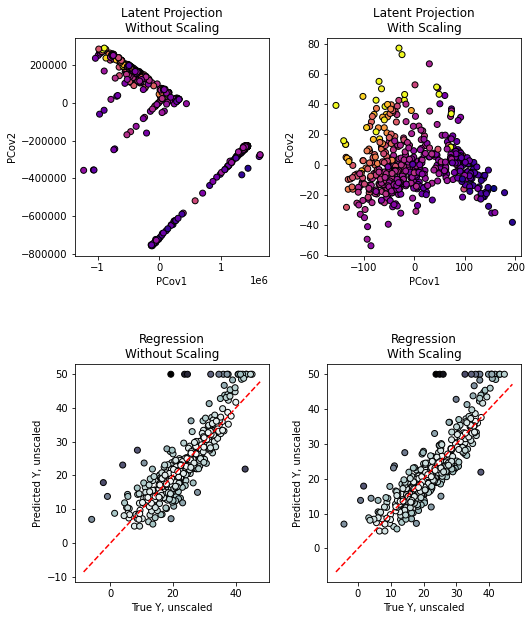

In [5]:
pcovr_unscaled = PCovR(mixing=0.5).fit(X, y)
T_unscaled = pcovr_unscaled.transform(X)
Yp_unscaled = pcovr_unscaled.predict(X)

pcovr_scaled = PCovR(mixing=0.5).fit(X_scaled, y_scaled)
T_scaled = pcovr_scaled.transform(X_scaled)
Yp_scaled = y_scaler.inverse_transform(pcovr_scaled.predict(X_scaled))


fig, ((ax1_T, ax2_T), (ax1_Y, ax2_Y)) = plt.subplots(2, 2, figsize=(8, 10))

ax1_T.scatter(T_unscaled[:, 0], T_unscaled[:, 1], c=y, cmap="plasma", ec="k")
ax1_T.set_xlabel("PCov1")
ax1_T.set_ylabel("PCov2")
ax1_T.set_title("Latent Projection\nWithout Scaling")

ax2_T.scatter(T_scaled[:, 0], T_scaled[:, 1], c=y, cmap="plasma", ec="k")
ax2_T.set_xlabel("PCov1")
ax2_T.set_ylabel("PCov2")
ax2_T.set_title("Latent Projection\nWith Scaling")

ax1_Y.scatter(Yp_unscaled, y, c=np.abs(y - Yp_unscaled), cmap="bone_r", ec="k")
ax1_Y.plot(ax1_Y.get_xlim(), ax1_Y.get_xlim(), "r--")
ax1_Y.set_xlabel("True Y, unscaled")
ax1_Y.set_ylabel("Predicted Y, unscaled")
ax1_Y.set_title("Regression\nWithout Scaling")

ax2_Y.scatter(Yp_scaled, y, c=np.abs(y - Yp_scaled), cmap="bone_r", ec="k")
ax2_Y.plot(ax2_Y.get_xlim(), ax2_Y.get_xlim(), "r--")
ax2_Y.set_xlabel("True Y, unscaled")
ax2_Y.set_ylabel("Predicted Y, unscaled")
ax2_Y.set_title("Regression\nWith Scaling")

fig.subplots_adjust(hspace=0.5, wspace=0.3)

Also, we see that the total loss (loss in recreating the original dataset and regression loss) does not vary with `mixing` as expected when the datasets are unscaled. Typically, the regression loss should _gradually_ increase with `mixing` (and vice-versa for the loss in reconstructing the original features). When the inputs are not scaled, however, there will often be a sharp drop or jump in the losses as `mixing` goes to 0 or 1, depending on which input is dominating the results of the model. Here, because the features dominate the model, this jump occurs as `mixing` goes to 0.

Text(0, 0.5, 'Loss $\\ell$')

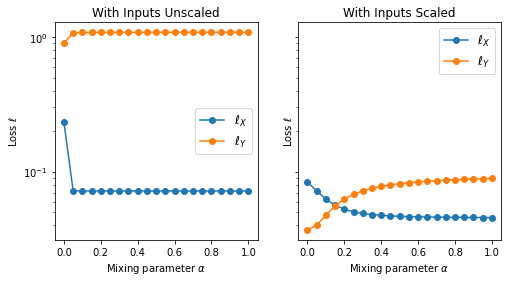

In [6]:
mixings = np.linspace(0, 1, 21)
losses_unscaled = np.zeros((2, len(mixings)))
losses_scaled = np.zeros((2, len(mixings)))

for mi, mixing in enumerate(mixings):
    pcovr_unscaled = PCovR(mixing=mixing, n_components=1).fit(X, y)
    t_unscaled = pcovr_unscaled.transform(X)
    yp_unscaled = pcovr_unscaled.predict(T=t_unscaled)
    xr_unscaled = pcovr_unscaled.inverse_transform(t_unscaled)
    losses_unscaled[:, mi] = (
        np.linalg.norm(xr_unscaled - X) ** 2.0 / np.linalg.norm(X) ** 2,
        np.linalg.norm(yp_unscaled - y) ** 2.0 / np.linalg.norm(y) ** 2,
    )

    pcovr_scaled = PCovR(mixing=mixing, n_components=1).fit(X_scaled, y_scaled)
    t_scaled = pcovr_scaled.transform(X_scaled)
    yp_scaled = y_scaler.inverse_transform(pcovr_scaled.predict(T=t_scaled))
    xr_scaled = x_scaler.inverse_transform(pcovr_scaled.inverse_transform(t_scaled))
    losses_scaled[:, mi] = (
        np.linalg.norm(xr_scaled - X) ** 2.0 / np.linalg.norm(X) ** 2,
        np.linalg.norm(yp_scaled - y) ** 2.0 / np.linalg.norm(y) ** 2,
    )
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)
ax1.semilogy(mixings, losses_unscaled[0], marker="o", label=r"$\ell_{X}$")
ax1.semilogy(mixings, losses_unscaled[1], marker="o", label=r"$\ell_{Y}$")
ax1.legend(fontsize=12)
ax1.set_title('With Inputs Unscaled')
ax1.set_xlabel(r'Mixing parameter $\alpha$')
ax1.set_ylabel(r'Loss $\ell$')

ax2.semilogy(mixings, losses_scaled[0], marker="o", label=r"$\ell_{X}$")
ax2.semilogy(mixings, losses_scaled[1], marker="o", label=r"$\ell_{Y}$")
ax2.legend(fontsize=12)
ax2.set_title('With Inputs Scaled')
ax2.set_xlabel(r'Mixing parameter $\alpha$')
ax2.set_ylabel(r'Loss $\ell$')

**Note: when the relative magnitude of the features or targets is important, such as in load_csd_1000r, one should use the `StandardFlexibleScaler` provided by `scikit-cosmo`.**